#  Curve fitting - How?

###  In this project, I will show the different libraries and methods to do curve fitting with Python. These methods differ in the way the objective function and Jacobian matrix are defined, in addition to some other capabilities.
    
### For the purpose of illustrating an example, I will introduce a limb model which I have been working on during my PhD. 

In [1]:
## importing the libraries
import numpy as np
import math as m
import scipy
import matplotlib.pyplot as plt
from scipy import special

In [2]:
def Erfc(x,sigma):

 y = special.erfc(x/(sigma*np.sqrt(2)))
 return y

## Introducing the model to be used later for the fitting

def SL_fit(x,w1,w2,w3,s1,s2,s3):

  f = 0.5*(w1*Erfc(x,s1)+w2*Erfc(x,s2)+w3*Erfc(x,s3)+ (1-w1-w2-w3))
  return f

### The first method we will use is via __[scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)__ 

In [4]:
from scipy.optimize import curve_fit

In [5]:
#This is the jacobian matrx, which is the derivative of the fitting function with respect to every free parameter
def DF(x,w1,w2,w3,s1,s2,s3):
 dfw1 = 0.5*(Erfc(x,s1)-1)
 dfw2 = 0.5*(Erfc(x,s2)-1)
 dfw3 =  0.5*(Erfc(x,s3)-1)
 dfs1 = w1*x*np.exp(-x**2/(2*s1**2))/ (np.sqrt(2*np.pi)*s1**2)
 dfs2 = w2*x*np.exp(-x**2/(2*s2**2))/ (np.sqrt(2*np.pi)*s2**2)
 dfs3 = w3*x*np.exp(-x**2/(2*s3**2))/ (np.sqrt(2*np.pi)*s3**2)
 return np.transpose(np.array([dfw1,dfw2,dfw3,dfs1,dfs2,dfs3]))


In [25]:
## Loading the data:
path = "/home/fatima/Desktop/project_3/"
file = np.loadtxt(path+'limb_profile_av_norm_shifted')
x = file[:,0]
y = file[:,1]

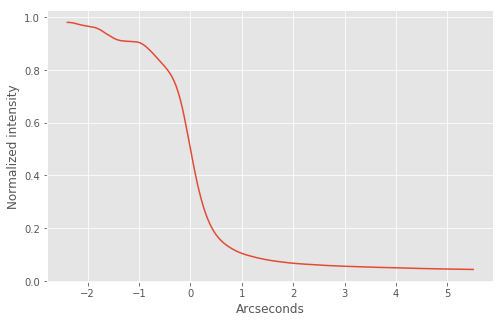

In [26]:
## plotting the data
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.plot(x,y)
plt.xlabel('Arcseconds')
plt.ylabel('Normalized intensity')
plt.show()

In [27]:
## For the purpose of fitting, we restrict the latter to data points located above x = 0
ind = np.where(x>=0)
x = x[ind]
y = y[ind]
weights = np.sqrt(np.abs(y)) ## Poisson weighting

In [49]:
p0=[0.3, 0.3, 0.2, 1, 2, 3] ## initial guess best-fit parameters
popt, pcov = curve_fit(SL_fit,x,y,p0,method='lm',sigma=weights,jac=DF,ftol=1e-8,xtol=1e-8,maxfev=5000)
chi_sq = np.sum((1/weights**2)*(SL_fit(x,*popt)-y)**2)

In [54]:
print popt #to view the best fit parameters
print chi_sq

[ 0.52750103  0.28882569  0.10191755  0.25905336  0.76540583  2.83343005]
0.00122093770376


In [48]:
xnew = np.linspace(x.min(),x.max(),1000)
y_fit = SL_fit(xnew,*popt)

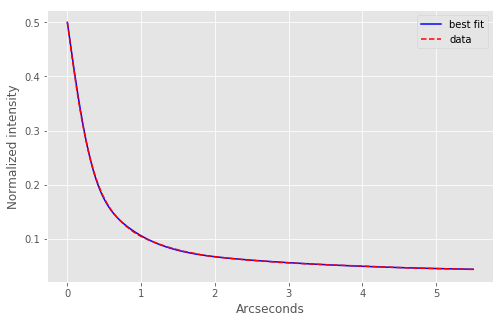

In [35]:
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.plot(xnew, y_fit,color='blue', label='best fit')
plt.plot(x,y,'r--', label='data')
plt.xlabel('Arcseconds')
plt.ylabel('Normalized intensity')
plt.legend(loc='upper right')
plt.show()

### The second method we will use is via __[scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squals)__ . With this module, both he objective function and jacobian matrix have to be defined differently than in __[scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)__ :

In [39]:
from scipy.optimize import least_squares

In [40]:
## objective function
def Leastsquares(params, x,y,w):
 w1 = params[0]
 w2 = params[1]
 w3 = params[2]
 s1 = params[3]
 s2 = params[4]
 s3 = params[5]
 model = 0.5*(w1*Erfc(x,s1)+w2*Erfc(x,s2)+w3*Erfc(x,s3)+(1-w1-w2-w3))
 return (1/w)*(model-y)

## as you can see, in the objective function has to return the difference between the modelled data and data points

In [41]:
## jacobian matrix
def Jac(popt,x,y,w):
 w1 = popt[0]
 w2 = popt[1]
 w3 = popt[2]
 s1 = popt[3]
 s2 = popt[4]
 s3 = popt[5]
 dfw1 = 0.5*(Erfc(x,s1)-1)
 dfw2 = 0.5*(Erfc(x,s2)-1)
 dfw3 =  0.5*(Erfc(x,s3)-1)
 dfs1 = w1*x*np.exp(-x**2/(2*s1**2))/ (np.sqrt(2*np.pi)*s1**2)
 dfs2 = w2*x*np.exp(-x**2/(2*s2**2))/ (np.sqrt(2*np.pi)*s2**2)
 dfs3 = w3*x*np.exp(-x**2/(2*s3**2))/ (np.sqrt(2*np.pi)*s3**2)
 return np.transpose(np.array(1/w)*([dfw1,dfw2,dfw3,dfs1,dfs2,dfs3]))


In [42]:
## loading the data again:
x = file[:,0]
y = file[:,1]

ind = np.where(x>=0)
x = x[ind]
y = y[ind]
weights = np.sqrt(np.abs(y)) ## Poisson weighting

In [52]:
## calling the objective function and fitting data points
res_leastsquares = least_squares(Leastsquares, p0,method='lm',jac=Jac, args=(x,y,weights),ftol=1e-8,xtol=1e-8,max_nfev=5000)
##computing the chi-square value
chi_sq_2 = np.sum((Leastsquares(res_leastsquares.x,x,y,weights))**2)

In [53]:
## printing best-fit parameters
print res_leastsquares.x
print chi_sq_2

[ 0.52750174  0.28882527  0.10191733  0.2590536   0.76540736  2.83343784]
0.00122093770322


### The THIRD method we will use is via __[scipy.optimize.leasq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html)__ , which is pretty similar to __[scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squals)__ except for the saved results format

In [55]:
from scipy.optimize import leastsq

In [56]:
## objective function
def Leastsq(params, x,y,w):
 w1 = params[0]
 w2 = params[1]
 w3 = params[2]
 s1 = params[3]
 s2 = params[4]
 s3 = params[5]
 model = 0.5*(w1*Erfc(x,s1)+w2*Erfc(x,s2)+w3*Erfc(x,s3)+(1-w1-w2-w3))
 return (1/w)*(model-y)

##jacobian matrix same as in leastsquares method

In [57]:
res_leastsq = leastsq(Leastsq,p0,args=(x,y,weights),Dfun=Jac,ftol=1e-8,xtol=1e-8,maxfev=5000)
chi_sq_3 = np.sum((Leastsq(res_leastsq[0],x,y,weights))**2)

In [58]:
print res_leastsq[0]
print chi_sq_3

[ 0.52750103  0.28882569  0.10191755  0.25905336  0.76540583  2.83343005]
0.00122093770376


### The FOURTH method we will use is the powerful package __[lmfit](https://lmfit.github.io/lmfit-py/)__ . LMFIT has the advantage of fixing certain parameters while letting others unchanged, and the possibiliy to introduce bounds on the variables.

In [71]:
import lmfit
from lmfit import Minimizer, minimize, Parameters, report_fit

In [63]:
## defining the objective function
def residual(params, x,y,w):
 w1 = params['omega1']
 w2 = params['omega2']
 w3 = params['omega3']
 s1 = params['sigma1']
 s2 = params['sigma2']
 s3 = params['sigma3']

 model = 0.5*(w1*Erfc(x,s1)+w2*Erfc(x,s2)+w3*Erfc(x,s3)+(1-w1-w2-w3))

 return (1/w)*(y-model)

In [65]:
# using the class Parameters in which we can name the variables and assign first guess values and boundaries, if needed
params = Parameters()
params.add('omega1', value=0.3)
params.add('omega2', value=0.3)
params.add('omega3', value=0.3)
params.add('sigma1', value=1)
params.add('sigma2', value=2)
params.add('sigma3',value=3)

In [67]:
## fitting with lmfit via lmfit.minimize
out = lmfit.minimize(residual,params,method='leastsq',args=(x,y,weights),ftol=1e-8,xtol=1e-8,maxfev=5000)

In [74]:
## printing output
report_fit(out.params)

[[Variables]]
    omega1:   0.52750083 +/- 0.003494 (0.66%) (init= 0.3)
    omega2:   0.28882580 +/- 0.002845 (0.99%) (init= 0.3)
    omega3:   0.10191760 +/- 0.001193 (1.17%) (init= 0.3)
    sigma1:   0.25905329 +/- 0.001357 (0.52%) (init= 1)
    sigma2:   0.76540540 +/- 0.007152 (0.93%) (init= 2)
    sigma3:   2.83342789 +/- 0.047380 (1.67%) (init= 3)
[[Correlations]] (unreported correlations are <  0.100)
    C(omega1, sigma2)            =  0.899 
    C(omega1, omega2)            = -0.895 
    C(omega1, sigma1)            =  0.889 
    C(omega3, sigma2)            = -0.870 
    C(omega3, sigma3)            = -0.853 
    C(omega2, sigma1)            = -0.851 
    C(sigma2, sigma3)            =  0.729 
    C(sigma1, sigma2)            =  0.716 
    C(omega2, sigma2)            = -0.632 
    C(omega1, omega3)            = -0.628 
    C(omega1, sigma3)            =  0.487 
    C(omega3, sigma1)            = -0.457 
    C(sigma1, sigma3)            =  0.348 
    C(omega2, omega3)        

###  As you can see, the output is much nicer with lmfit, where uncertainties are displayed along the best-fit parameters, as well as the correlation coefficients between the parameters. 